In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
#load data
icu_data = pd.read_csv('icu/icustays_cleaned.csv')
diagnosis = pd.read_csv('ed/diagnosis_cleaned.csv')
triage = pd.read_csv('ed/triage_cleaned.csv')
vitals = pd.read_csv('ed/vitals_cleaned.csv')
ed_stays = pd.read_csv('ed/edstays_cleaned.csv')

# Combine the icd_version and icd_code columns in diagnosis table
diagnosis['icd_combined'] = diagnosis['icd_version'].astype(str) + '-' + diagnosis['icd_code'].astype(str)
print("We will combine the icd_combined and icd_version columns in the diagnosis table.")
print(diagnosis.head())


We will combine the icd_combined and icd_version columns in the diagnosis table.
   subject_id   stay_id  seq_num icd_code  icd_version  \
0    10000032  32952584        1     4589            9   
1    10000032  32952584        2    07070            9   
2    10000032  32952584        3      V08            9   
3    10000032  39399961        1    78097            9   
4    10000032  39399961        2    34830            9   

                                           icd_title icd_combined  
0                                    HYPOTENSION NOS       9-4589  
1  UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...      9-07070  
2                         ASYMPTOMATIC HIV INFECTION        9-V08  
3                             ALTERED MENTAL STATUS       9-78097  
4                        ENCEPHALOPATHY, UNSPECIFIED      9-34830  


Following code links emergency department (ED) stays with ICU admissions and their corresponding length of stay (los). The resulting DataFrame is essential for downstream tasks like predictive modeling or analysis of ICU utilization based on ED visit data.

In [3]:
# Merge datasets
merged_ed_icu = ed_stays[['stay_id', 'hadm_id']].merge(icu_data[['hadm_id', 'los']], on='hadm_id', how='inner')
merged_ed_icu = merged_ed_icu[['stay_id', 'hadm_id', 'los']]

print("We will now link the ed stays table with the ICU admissions and their corresponding length of stay (los).")
print(merged_ed_icu.head())

We will now link the ed stays table with the ICU admissions and their corresponding length of stay (los).
    stay_id     hadm_id       los
0  32952584  29079034.0  0.410266
1  39399961  29079034.0  0.410266
2  30905710  26913865.0  0.497535
3  39866888  24597018.0  1.118032
4  34719194  26184834.0  9.171817


In [ ]:
print("We will now preprocess the emergency department data with our desired features.")
print("Processing...")

date_format = '%Y-%m-%d %H:%M:%S'

def calculate_slope(df, col):
    df = df.sort_values('charttime').dropna(subset=[col])  # Drop NaN rows
    time_delta = (pd.to_datetime(df['charttime'], format=date_format) - pd.to_datetime(df['charttime'], format=date_format).min()).dt.total_seconds()

    if len(time_delta.unique()) < 2 or df[col].nunique() < 2:
        return np.nan

    slope = np.polyfit(time_delta, df[col], 1)[0]
    return slope


# Aggregate vitals data
vitals_summary = vitals.groupby('stay_id').agg({
    'heartrate': 'mean',
    'resprate': 'mean',
    'o2sat': 'mean',
    'sbp': 'mean',
    'dbp': 'mean'
}).reset_index()

# Calculate slopes
slope_data = vitals.groupby('stay_id').apply(
    lambda x: pd.Series({
        'heartrate_slope': calculate_slope(x, 'heartrate'),
        'resprate_slope': calculate_slope(x, 'resprate'),
        'o2sat_slope': calculate_slope(x, 'o2sat'),
        'sbp_slope': calculate_slope(x, 'sbp'),
        'dbp_slope': calculate_slope(x, 'dbp')
    })
).reset_index()

# Merge triage and vitals summary
merged_features = triage.merge(vitals_summary, on='stay_id', how='left')

# Merge slopes into merged_features
merged_features = merged_features.merge(slope_data, on='stay_id', how='left')

# Retain only desired columns
ed_features = merged_features[[
    'stay_id', 'heartrate_x', 'resprate_x', 'o2sat_x', 'sbp_x', 'dbp_x',
    'heartrate_y', 'resprate_y', 'o2sat_y', 'sbp_y', 'dbp_y', 
    'heartrate_slope', 'resprate_slope', 'o2sat_slope', 'sbp_slope', 'dbp_slope'
]]

# Verify result
print(ed_features.head())

We will now preprocess the emergency department data with our desired features.
Processing...


TypeError: DataFrame.groupby() got an unexpected keyword argument 'include_groups'

In [5]:
#Merge ED features with ICU and Diagnosis Data
final_data = pd.merge(ed_features, merged_ed_icu[['stay_id', 'hadm_id', 'los']], on='stay_id', how='inner')
final_data = pd.merge(final_data, diagnosis[['stay_id', 'icd_combined']], on='stay_id', how='left')
final_data = pd.merge(final_data, ed_stays[['stay_id', 'intime', 'outtime']], on='stay_id', how='left')

# Verify result
print("We will now merge the emergency department data features with the ICU and diagnosis data.")
print(final_data.head())

We will now merge the emergency department data features with the ICU and diagnosis data.
    stay_id  heartrate_x  resprate_x  o2sat_x  sbp_x  dbp_x  heartrate_y  \
0  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
1  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
2  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
3  39399961         77.0        16.0     98.0   96.0   50.0    85.727273   
4  39399961         77.0        16.0     98.0   96.0   50.0    85.727273   

   resprate_y    o2sat_y      sbp_y  ...  heartrate_slope  resprate_slope  \
0   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
1   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
2   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
3   16.909091  94.363636  84.181818  ...         0.000785       -0.000081   
4   16.909091  94.363636  84.181818  ...         0.000785       -0.0

In [6]:
# Impute missing values
def impute_missing_values(df, numeric_features, non_numeric_features):
    # Impute numeric columns using the mean
    numeric_imputer = SimpleImputer(strategy='mean')
    df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])
    
    # Impute non-numeric columns with a constant value, e.g., 'unknown'
    non_numeric_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
    df[non_numeric_features] = non_numeric_imputer.fit_transform(df[non_numeric_features])
    
    return df

# Define numeric and non-numeric features for imputation
numeric_features = ['heartrate_x', 'resprate_x', 'o2sat_x', 'sbp_x', 'dbp_x',
                    'heartrate_y', 'resprate_y', 'o2sat_y', 'sbp_y', 'dbp_y', 
                    'heartrate_slope', 'resprate_slope', 'o2sat_slope', 'sbp_slope', 'dbp_slope'
                    ]
non_numeric_features = ['icd_combined']

In [7]:
# Apply the imputation function
final_data = impute_missing_values(final_data, numeric_features, non_numeric_features)

# Function to calculate and handle outliers
def remove_outliers(df, col_ranges):
    for col_prefix, (min_val, max_val) in col_ranges.items():
        # Handle both '_x' and '_y' columns for each vital sign
        for suffix in ['_x', '_y']:
            col = col_prefix + suffix
            if col in df.columns:
                df[col] = np.where(df[col] < min_val, min_val, df[col])
                df[col] = np.where(df[col] > max_val, max_val, df[col])
    return df

# Define column ranges for vital signs
col_ranges = {
    'heartrate': (30, 180),
    'resprate': (8, 60),
    'o2sat': (50, 100),
    'sbp': (60, 250),
    'dbp': (30, 150),
}

# Apply outlier removal
final_data = remove_outliers(final_data, col_ranges)

# Verify result
print("After imputing missing values and removing outliers:")
print(final_data.head())

After imputing missing values and removing outliers:
    stay_id  heartrate_x  resprate_x  o2sat_x  sbp_x  dbp_x  heartrate_y  \
0  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
1  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
2  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
3  39399961         77.0        16.0     98.0   96.0   50.0    85.727273   
4  39399961         77.0        16.0     98.0   96.0   50.0    85.727273   

   resprate_y    o2sat_y      sbp_y  ...  heartrate_slope  resprate_slope  \
0   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
1   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
2   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
3   16.909091  94.363636  84.181818  ...         0.000785       -0.000081   
4   16.909091  94.363636  84.181818  ...         0.000785       -0.000081   

   o2sat_slope  sbp_slope  

In [ ]:
print("Now normalizing data...")

# Prepare ED los data for normalization
final_data['intime'] = pd.to_datetime(final_data['intime'])
final_data['outtime'] = pd.to_datetime(final_data['outtime'])
final_data['ed_los'] = (final_data['outtime'] - final_data['intime']).dt.total_seconds() / 3600 # convert to hours

# Normalize data
id_columns = ['stay_id', 'hadm_id', 'icd_combined', 'los']
normalize_cols = ['heartrate_x', 'resprate_x', 'o2sat_x', 'sbp_x', 'dbp_x', 
                  'heartrate_y', 'resprate_y', 'o2sat_y', 'sbp_y', 'dbp_y', 
                  'heartrate_slope', 'resprate_slope', 'o2sat_slope', 'sbp_slope', 'dbp_slope', 'ed_los']

# Separate data into two parts: identifiers and features to normalize
id_data = final_data[id_columns].copy()
features_to_normalize = final_data[normalize_cols].copy()

# Handle missing values in features before normalization
features_to_normalize.fillna(features_to_normalize.mean(), inplace=True)

# Normalize only the numeric columns
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_to_normalize)
normalized_features_df = pd.DataFrame(normalized_features, columns=normalize_cols)

# Concatenate the identifier columns with the normalized features
final_data_normalized = pd.concat([id_data.reset_index(drop=True), normalized_features_df.reset_index(drop=True)], axis=1)

# Handle missing values in non-numeric columns
final_data_normalized['icd_combined'] = final_data_normalized['icd_combined'].fillna('unknown')

# Save the processed data
final_data_normalized.to_csv('preprocessed_data.csv', index=False)
print("Final preprocessed data saved to 'preprocessed_data.csv'")

# Size of final_data_normalized
print(f"Shape of the file: {final_data_normalized.shape}")

Final preprocessed data saved to 'preprocessed_data.csv'
Shape of the file: (75509, 20)


In [9]:
# regression model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load the preprocessed data
data = pd.read_csv('preprocessed_data.csv')

# Define features and target
X = data.drop(columns=['stay_id', 'hadm_id', 'icd_combined', 'los', 'ed_los'])
y = data['los']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("We will now train a linear regression model.")

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Calculate the mean squared error
lr_mse = mean_squared_error(y_test, lr_predictions)

# Calculate the R-squared
ls_r2 = r2_score(y_test, lr_predictions)

print(f'Linear Regression MSE: {lr_mse:.2f}')
print(f'Linear Regression R2: {ls_r2:.2f}')
print('\n')

print("We will now train a random forest model.")

# Train a random forest model
rf_model = RandomForestRegressor(n_estimators=250, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)

# Calculate the R-squared
rf_r2 = r2_score(y_test, rf_predictions)

print(f'Random Forest MSE: {rf_mse:.2f}')
print(f'Random Forest R2: {rf_r2:.2f} \n')

print("We see that the random forest model outperformed the linear regression model.\nWe will continue to use the random forest as our regression model.")

# The commented code tested the effect of the number of trees on the random forest model. Decided on n_estimators = 250 for the final model.

# n_estimators_range = [100, 200, 500]
# mse_values = []
# 
# for n_estimators in n_estimators_range:
#     rf_model = RandomForestRegressor(n_estimators = n_estimators, random_state=42)
#     rf_model.fit(X_train, y_train)
#     rf_predictions = rf_model.predict(X_test)
#     mse = mean_squared_error(y_test, rf_predictions)
#     mse_values.append(mse)
#     print(f'Random Forest (n_estimators={n_estimators}) MSE: {mse:.2f}')
#     
# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(n_estimators_range, mse_values, marker='o')
# plt.xlabel('Number of Trees')
# plt.ylabel('Mean Squared Error')
# plt.title('Effect of Number of Trees on Random Forest Performance')
# plt.grid(True)
# plt.show()

We will now train a linear regression model.
Linear Regression MSE: 24.89
Linear Regression R2: 0.00


We will now train a random forest model.
Random Forest MSE: 13.11
Random Forest R2: 0.47 

We see that the random forest model outperformed the linear regression model.
We will continue to use the random forest as our regression model.


In [10]:
# LSTM

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

print("We will now build and train an LSTM model.")

# Prepare data for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

seq_length = 10
sequences = create_sequences(data['ed_los'].values, seq_length)

X_lstm = sequences[:, :-1]
y_lstm = data['los'].values[seq_length - 1:]

# Split the data into training and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Reshape the data for LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Build an LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(seq_length, 1)))
lstm_model.add(LSTM(100, activation='relu', return_sequences=True))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_split=0.2)

# Make predictions using the LSTM model
lstm_predictions = lstm_model.predict(X_test_lstm)

# Calculate MSE of LSTM
lstm_mse = mean_squared_error(y_test_lstm, lstm_predictions)

# Calculate R-Squared of LSTM
lstm_r2 = r2_score(y_test_lstm, lstm_predictions)

print(f'LSTM Model MSE: {lstm_mse:.2f}')
print(f'LSTM Model R-squared: {lstm_r2:.2f}')

We will now build and train an LSTM model.
Epoch 1/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 23.8887 - val_loss: 24.5730
Epoch 2/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 23.4927 - val_loss: 24.5392
Epoch 3/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 23.5099 - val_loss: 24.6717
Epoch 4/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 24.2152 - val_loss: 24.5187
Epoch 5/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 23.7990 - val_loss: 24.5542
Epoch 6/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 22.2763 - val_loss: 24.5009
Epoch 7/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 23.3823 - val_loss: 24.5310
Epoch 8/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 23.0487 - val_loss: 24.6071
Epoch 9/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 23.4353 - val_loss: 24.5155
Epoch 10/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 24.3309 - val_loss: 24.5605
Epoch 11/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s

In [11]:
# Calculate the variance of the target variable
target_variance = np.var(y_test)
print(f'Variance of the target variable: {target_variance:.2f}')

# Calculate the MSE of a baseline model (predicting the mean of the target variable)
baseline_predictions = np.full_like(y_test, np.mean(y_test))
baseline_mse = mean_squared_error(y_test, baseline_predictions)
baseline_r2 = r2_score(y_test, baseline_predictions)
print(f'Baseline Model MSE: {baseline_mse:.2f}')
print(f'Baseline Model R2: {baseline_r2:.2f}')

Variance of the target variable: 24.94
Baseline Model MSE: 24.94
Baseline Model R2: 0.00


In [12]:
print("We will now evaluate the combined model of the random forest and LSTM models:")

from sklearn.metrics import r2_score

min_length = min(len(rf_predictions), len(lstm_predictions))

rf_predictions = rf_predictions[:min_length]
lstm_predictions = lstm_predictions[:min_length].flatten()

# Combine LSTM and Random Forest Predictions
combined_predictions = (rf_predictions + lstm_predictions) / 2

# Evaluate combined model
combined_mse = mean_squared_error(y_test[:min_length], combined_predictions)
print(f'Combined Model MSE: {combined_mse:.2f}')

# Calculate R-squared for the combined model
r2_combined = r2_score(y_test[:min_length], combined_predictions)
print(f'Combined Model R-squared: {r2_combined:.2f}')

We will now evaluate the combined model of the random forest and LSTM models:
Combined Model MSE: 16.39
Combined Model R-squared: 0.34


In [17]:
print("\n")
print("We see that the random forest model and then the combined model had the best performances per their MSE scores.\nThey also outperformed the baseline model.")



We see that the random forest model and then the combined model had the best performances per their MSE scores.
They also outperformed the baseline model.


We will now plot the random forest model.


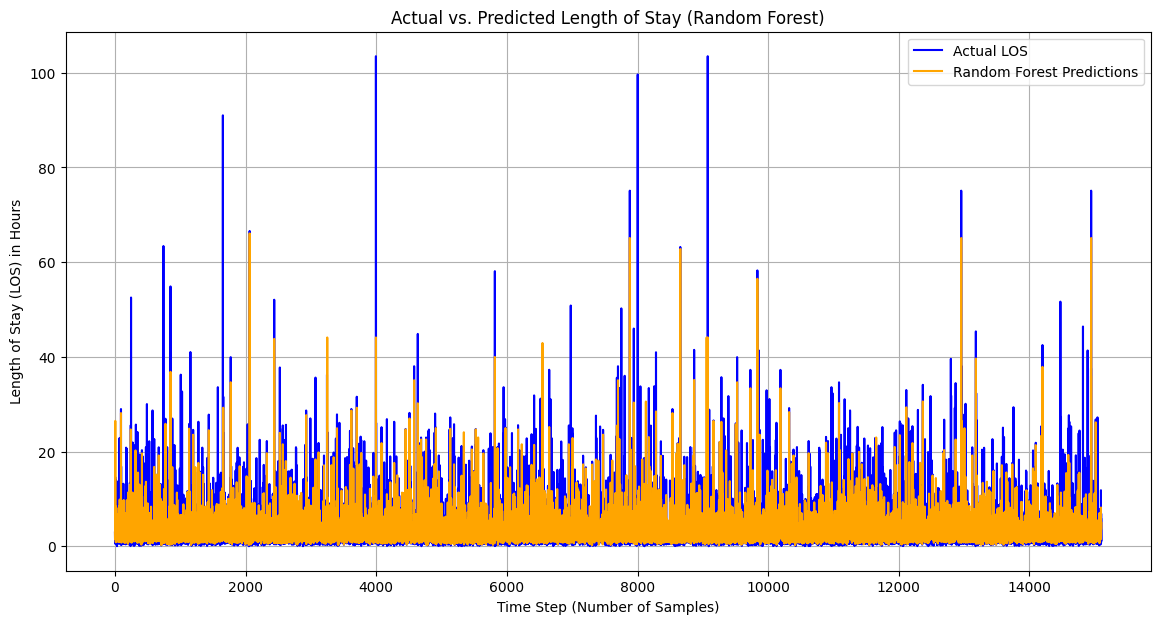

In [14]:
print("We will now plot the random forest model.")

# Plot the actual and predicted LOS values from Random Forest model
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual LOS', color='blue')
plt.plot(rf_predictions, label='Random Forest Predictions', color='orange')
plt.xlabel('Time Step (Number of Samples)')
plt.ylabel('Length of Stay (LOS) in Hours')
plt.title('Actual vs. Predicted Length of Stay (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

We will now plot the combined model.


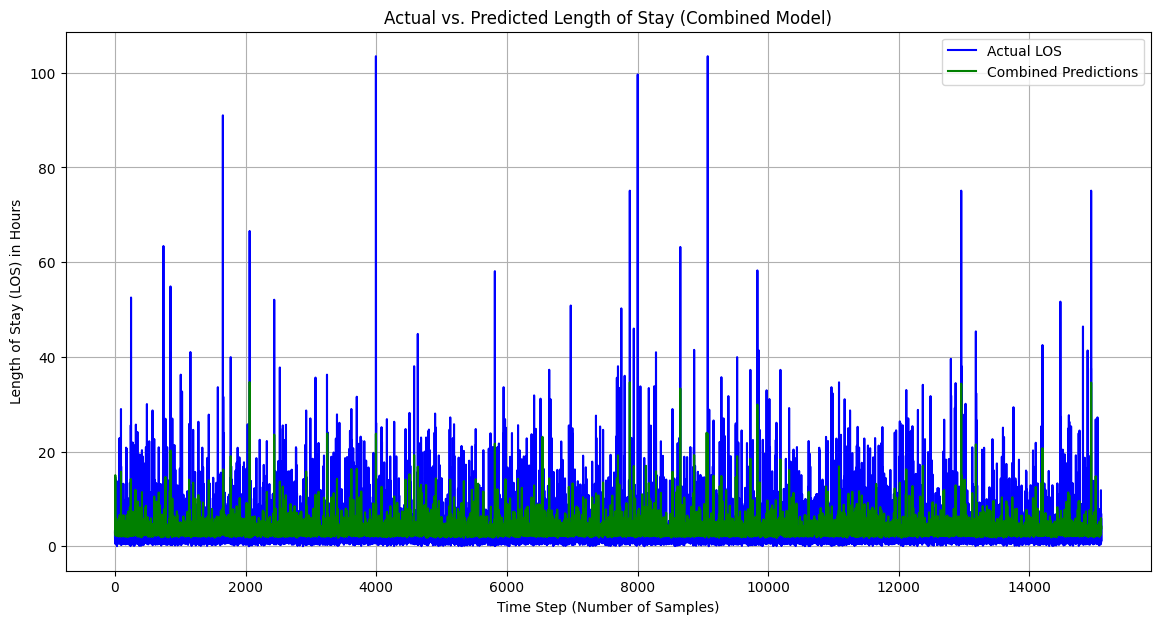

In [15]:
print("We will now plot the combined model.")

# Plot the actual and predicted LOS values from combined model

plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual LOS', color='blue')
plt.plot(combined_predictions, label='Combined Predictions', color='green')
plt.xlabel('Time Step (Number of Samples)')
plt.ylabel('Length of Stay (LOS) in Hours')
plt.title('Actual vs. Predicted Length of Stay (Combined Model)')
plt.legend()
plt.grid(True)
plt.show()

We will now plot the LSTM model.


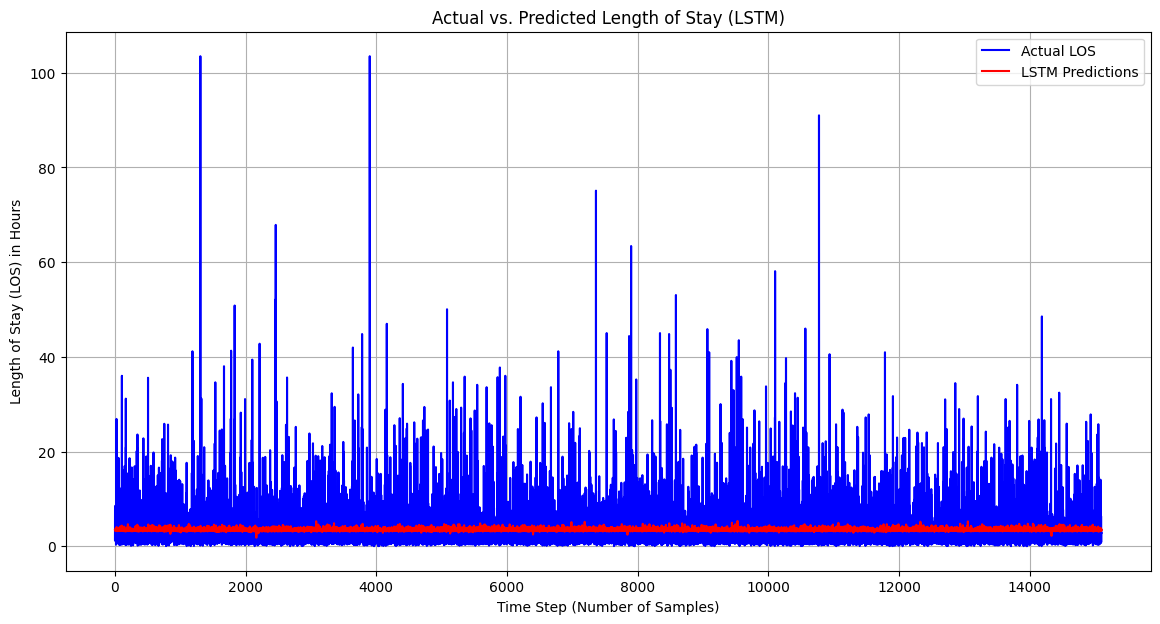

In [16]:
print("We will now plot the LSTM model.")

# Plot the actual and predicted LOS values from LSTM model

plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm, label='Actual LOS', color='blue')
plt.plot(lstm_predictions, label='LSTM Predictions', color='red')
plt.xlabel('Time Step (Number of Samples)')
plt.ylabel('Length of Stay (LOS) in Hours')
plt.title('Actual vs. Predicted Length of Stay (LSTM)')
plt.legend()
plt.grid(True)
plt.show()